# Let's start GWR bandwidth calibration with `sgGWR`!


## introduction

Welcome to **sgGWR**! sgGWR (Stochastic Gradient approach for Geographically Weighted Regression) is scalable bandwidth calibration software for GWR.

Hyperparameter tuning for GWR is time-consuming. `sgGWR` accelerates this process with a stochastic approximation of cross-validation error.
So `sgGWR`'s calibration is inaccurate but fast.

As a first example, let us estimate a regression model for the unknown function with spatial dependency. In practice, we often employ GWR models because we do not know the true functional form.

GWR is one of the most popular SVC (Spatially Varying Coefficient) models. SVC models are flexible and interpretable.
The weak point of GWR is the computational cost for hyperparameter calibration.
This hyperparameter is called bandwidth.

As a beginning, please install and import the following packages.
We strongly recommend installing [JAX](https://github.com/google/jax) for efficient computation, but `sgGWR` works even if you cannot install `jax`.

In [1]:
import numpy as np
from scipy import interpolate

from jax import numpy as jnp
from jax import random

import matplotlib.pyplot as plt

import sgGWR

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### set up training data

In this tutorial, we generate samples from a linear model with spatial coefficients. Beginners do not need to understand the next cell.

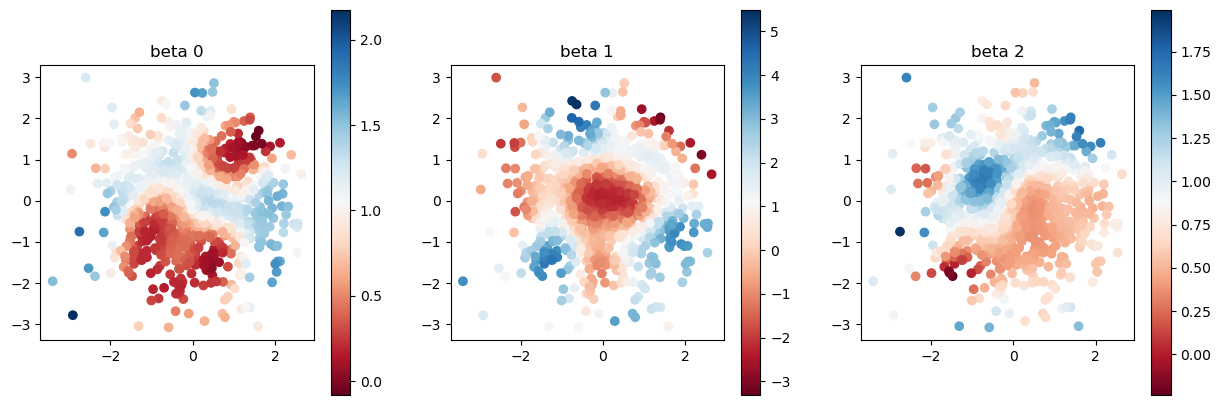

In [2]:
# This spatial coefficient model is inspired by Murakami et al. (2020)
def surface(sites, key, sigma, n_grid=30):
    s_min = jnp.min(sites, axis=0)
    s_max = jnp.max(sites, axis=0)

    x = jnp.linspace(s_min[0], s_max[0], num=n_grid)
    y = jnp.linspace(s_min[1], s_max[1], num=n_grid)
    x_ref, y_ref = np.meshgrid(x, y)
    x_ref = x_ref.flatten()
    y_ref = y_ref.flatten()
    ref = np.stack([x_ref, y_ref]).T

    d = np.linalg.norm(ref[:, None] - ref[None], axis=-1)
    G = jnp.exp(-d**2)

    beta_ref = random.multivariate_normal(key, mean=jnp.ones(len(ref)), cov=sigma**2*G, method="svd")

    interp = interpolate.RectBivariateSpline(x, y, beta_ref.reshape(n_grid, n_grid).T, s=0)
    beta = interp(sites[:,0], sites[:,1], grid=False)
    beta = jnp.array(beta)

    return beta

def DataGeneration(N, prngkey, sigma2=1.0):
    # sites
    key, prngkey = random.split(prngkey)
    sites = random.normal(key, shape=(N,2))

    # kernel
    G = jnp.linalg.norm(sites[:,None] - sites[None], axis=-1)
    G = jnp.exp(-jnp.square(G))

    # coefficients
    key, prngkey = random.split(prngkey)
    beta0 = surface(sites, key, sigma=0.5)
    # beta0 = random.multivariate_normal(key, mean=jnp.ones(N), cov=0.5**2 * G, method="svd")
    key, prngkey = random.split(prngkey)
    beta1 = surface(sites, key, sigma=2.0)
    # beta1 = random.multivariate_normal(key, mean=jnp.ones(N), cov=2.0**2 * G, method="svd")
    key, prngkey = random.split(prngkey)
    beta2 = surface(sites, key, sigma=0.5)
    # beta2 = random.multivariate_normal(key, mean=jnp.ones(N), cov=0.5**2 * G, method="svd")

    beta = jnp.stack([beta0, beta1, beta2]).T

    # X
    key, prngkey = random.split(prngkey)
    X = random.normal(key, shape=(N,2))
    X = jnp.concatenate([jnp.ones((N,1)), X], axis=1)

    # y
    y = beta0 + beta1 * X[:,1] + beta2 * X[:,2]
    key, prngkey = random.split(prngkey)
    y += sigma2**0.5 * random.normal(key, shape=(N,))

    return sites, y, X, beta

def plot_scatter(x, sites):
    fig = plt.figure(figsize=(15,5))
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        mappable = ax.scatter(sites[:,0], sites[:,1], c=x[:,i], cmap=plt.cm.RdBu)
        ax.set_title(f"beta {i}")
        ax.set_aspect("equal")
        fig.colorbar(mappable)
    # fig.show()

N = 1000
key = random.PRNGKey(123)
sites, y, X, beta = DataGeneration(N, key)
plot_scatter(beta, sites)

We show the scatter plot of the true coefficients of $\beta_0, \beta_1, \beta_2$.
We use the 1000 pairs of $(y_i, \bf{x}_i)$ to recover the coefficients. 
The relationship between $y$ and $\bf{x}$ is 

$$
y_i = \beta_{0i} + \beta_{1i} x_{i1} + \beta_{2i} x_{i2} + \varepsilon_i \\
{\bf{x}_i} = (1, x_{i0}, x_{i1})^\top
$$

The interesting point on this model is that the coefficients $\beta$ is not constant parameter and has spatial dependency.

## setup model

`sgGWR` contains two modules and one subpackage as follows:

- sgGWR models (`sgGWR.models`)
  - This module contains some Geographically Weighted Regression (GWR) Models.
- sgGWR kernels (`sgGWR.models`)
  - This module contains various kernel functions for GWR models.
- optimizers (`sgGWR.optimizers`)
  - This subpackage contains a lot of optimizers for bandwidth calibration.

In this stage, we define the model with the combination of `sgGWR.models` and `sgGWR.kernels`.

**kernel function**

At first, define the kernel function. Kernel function class has `params` argument, which will be the initial values of bandwidth calibration.
Here, we select 1.0 as a initial value at random.

In [3]:
kernel = sgGWR.kernels.Exponential(params=[1.0])

**model specification**

Next, defined kernel is used to specify the GWR model.

In [4]:
model = sgGWR.models.GWR(y=y, X=X, sites=sites, kernel=kernel)

## GWR without calibration

We have no reason to select 1.0 as a bandwidth parameter, but we can estimate GWR model without calibration.

To calculate spatially varying coefficients on training samples, run `model.set_betas_inner()` method and check `model.betas`.

Let us check estimated `model.betas` and true coefficients.

estimated coefficient without calibration


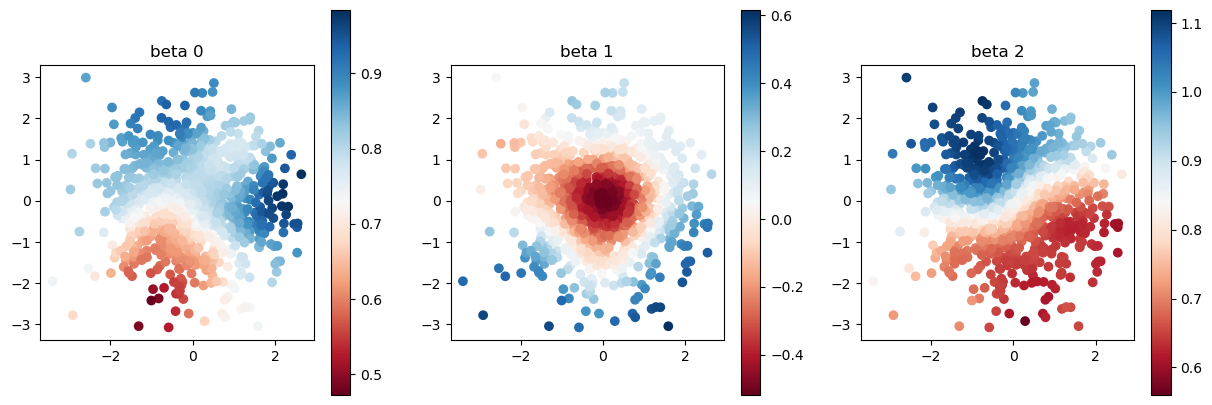

In [5]:
model.set_betas_inner()

print("estimated coefficient without calibration")
plot_scatter(model.betas, sites)

true coefficients


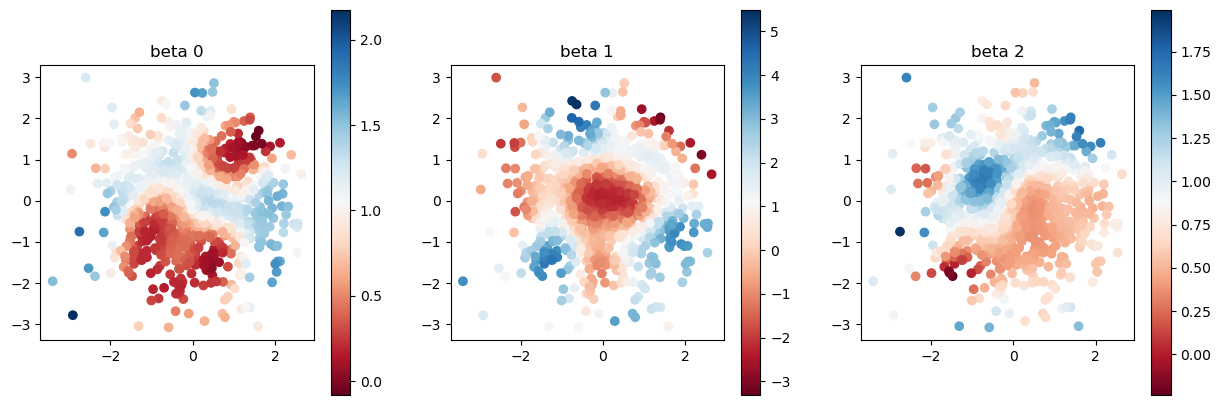

In [6]:
print("true coefficients")
plot_scatter(beta, sites)

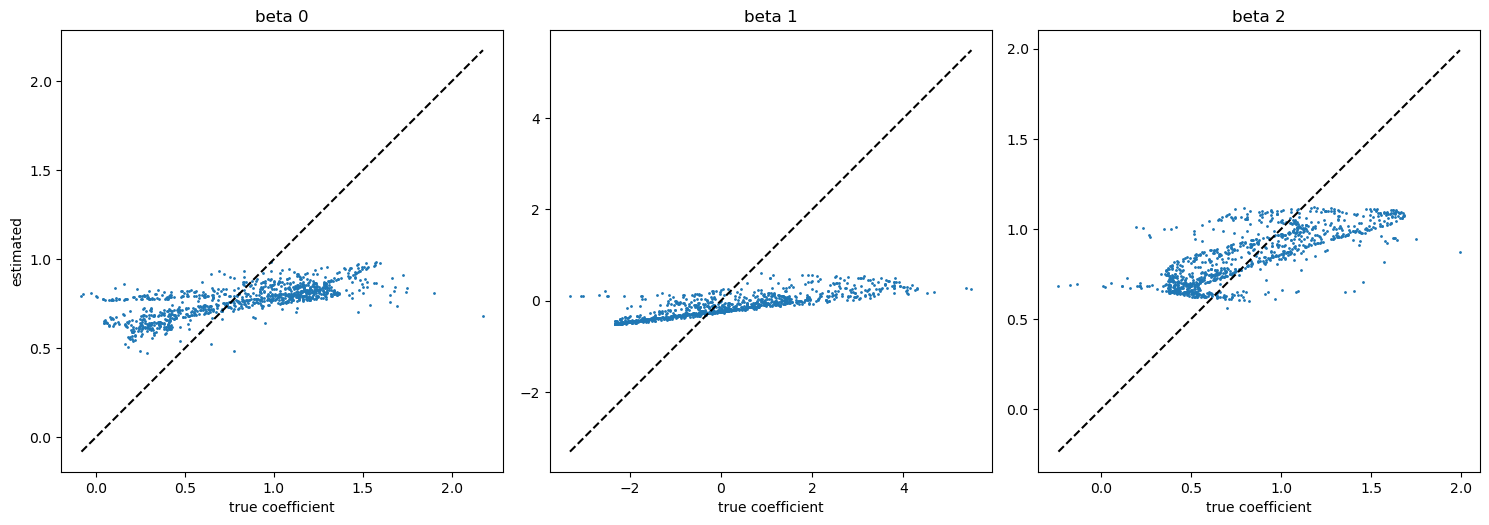

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    axes[i].plot((beta[:,i].min(), beta[:, i].max()), (beta[:,i].min(), beta[:, i].max()), c="k", ls="--")
    axes[i].scatter(beta[:,i], model.betas[:,i], s=1)
    axes[i].set_title(f"beta {i}")
    axes[i].set_aspect("equal")
    axes[i].set_xlabel("true coefficient")
axes[0].set_ylabel("estimated")

plt.tight_layout()
plt.show()


The last figure is the scatter plot of true v.s. estimated coefficients. If the estimation was accurate, blue dots were located on the black dashed line.

This estimated coefficient looks not so good. So, let us calibrate the bandwidth hyperparameter.

## setup optimizer and calibrate bandwidth

`sgGWR.optimizers` is a subpackage of `sgGWR`, and it contains various optimizers.
We recommend `SGDarmijo` as a first choice.
When we define the optimizer, we need to select initial learning rate with `learning_rate0` argument. Please carefully select this argument to effectively and successfully calibrate bandwidth (You may need some try and error).

In this setting, 100 samples (=`batchsize`) are randomly selected to approximate cross-validation error in each step during optimization.

In [8]:
optim = sgGWR.optimizers.SGDarmijo(learning_rate0=1.0)

loocv_loss = optim.run(model, maxiter=1000, batchsize=100)

print("calibrated bandwidth = ", model.kernel.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

calibrated bandwidth =  [7.834163]


**Check convergence**

We strongly recommend to check convergence by yourself because `sgGWR` automatically stop iteration when cross-validation error seems to be converged.

`SGDarmijo` returns the history of (approximated) cross-validation error.

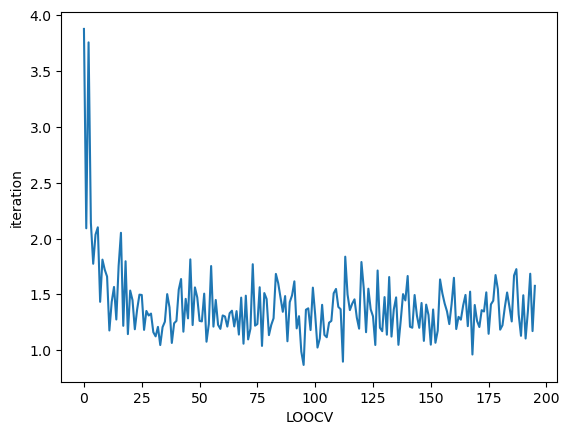

In [9]:
plt.plot(loocv_loss)
plt.xlabel("LOOCV")
plt.ylabel("iteration")
plt.show()

Let us compare true and estimated coefficients again. The estimation got far better thanks to the bandwidth calibration.

estimated coefficient after calibration


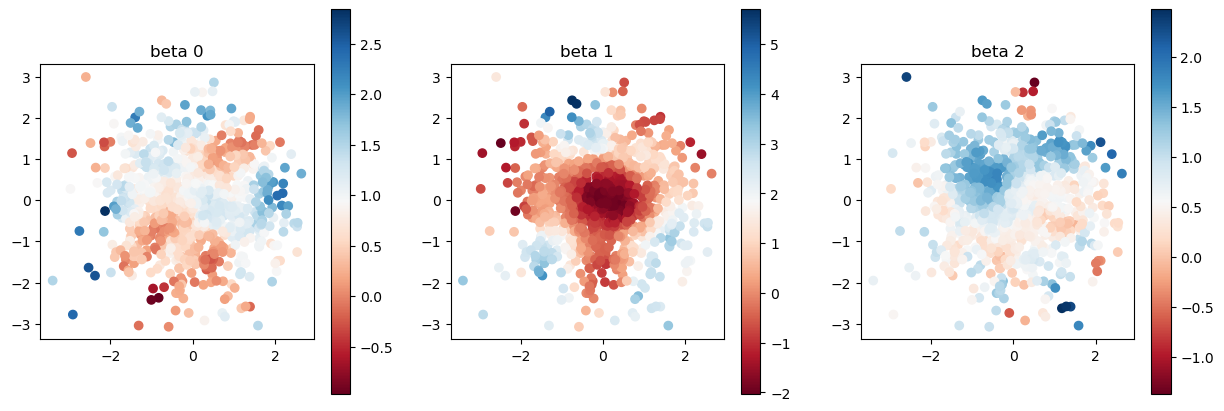

In [10]:
model.set_betas_inner()

print("estimated coefficient after calibration")
plot_scatter(model.betas, sites)

true coefficients


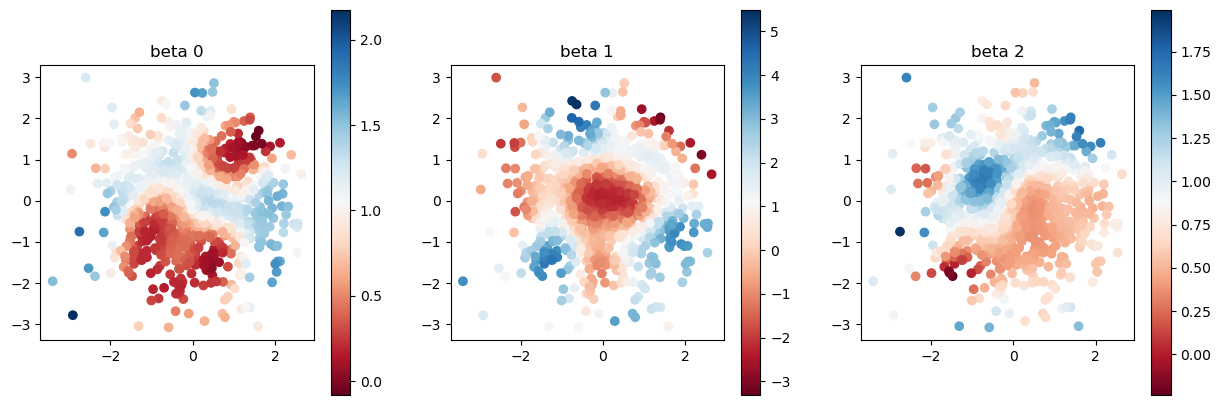

In [11]:
print("true coefficients")
plot_scatter(beta, sites)

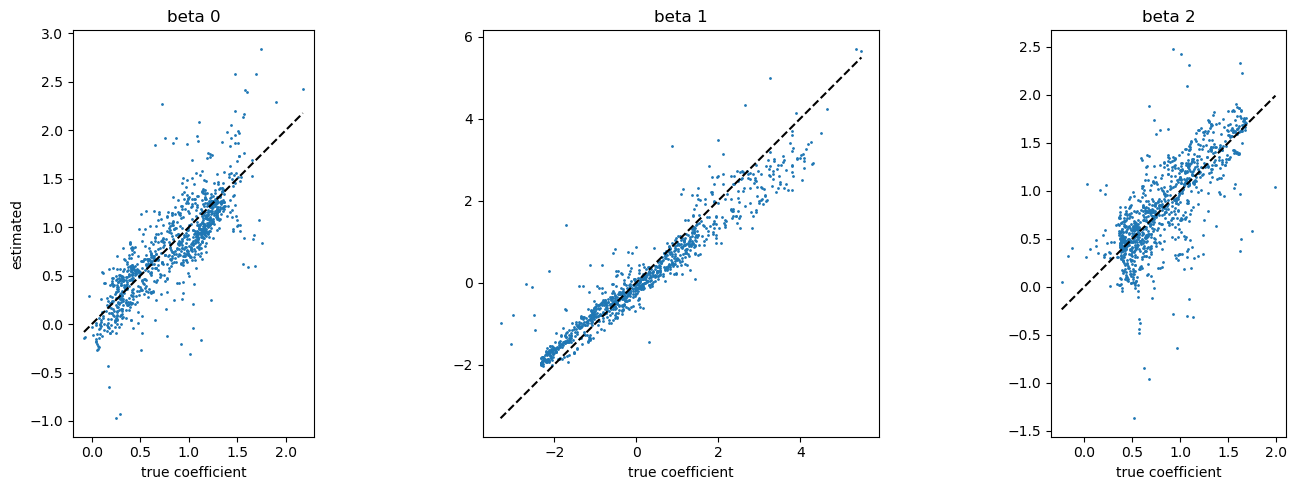

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    axes[i].plot((beta[:,i].min(), beta[:, i].max()), (beta[:,i].min(), beta[:, i].max()), c="k", ls="--")
    axes[i].scatter(beta[:,i], model.betas[:,i], s=1)
    axes[i].set_title(f"beta {i}")
    axes[i].set_aspect("equal")
    axes[i].set_xlabel("true coefficient")
axes[0].set_ylabel("estimated")

plt.tight_layout()
plt.show()


**Notes**

The estimation accuracy on $\beta_1$ looks better than the others. Why? Please check the absolute values of coefficients. It is because that $\beta_1$ has greater effect on the response variable $y$. 

In practice, initial value of bandwidth greatly affects the optimization efficency. If you choose 'good' initial value, you can save time to calibrate bandwidth. Please learn how to initialize the bandwidth in the tutorial **How should we initialize the bandwidth parameter before tuning?**.

## "polish" the bandwidth (optional)

If you mind the inaccurate optimization, you can improve the bandwidth with non-stochastic optimization method.
`scipy_optimizer` is a wrapper of `scipy.optimize.minimize`, and use the `model.kernel.params` as a initial value.

Hence, you can use stochastic optimization to find a good initial value for accurate calibration.

In [13]:
optim = sgGWR.optimizers.scipy_optimizer()

rslt = optim.run(model, method="l-bfgs-b")

print("calibrated bandwidth = ", model.kernel.params)

print(rslt)

calibrated bandwidth =  [7.4202375]
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 1.348891258239746
        x: [ 7.420e+00]
      nit: 3
      jac: [-1.233e-05]
     nfev: 46
     njev: 46
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


However, you can find that result of `SGDarmijo` is not so different from the result of accurate calibration.

estimated coefficient after accurate calibration


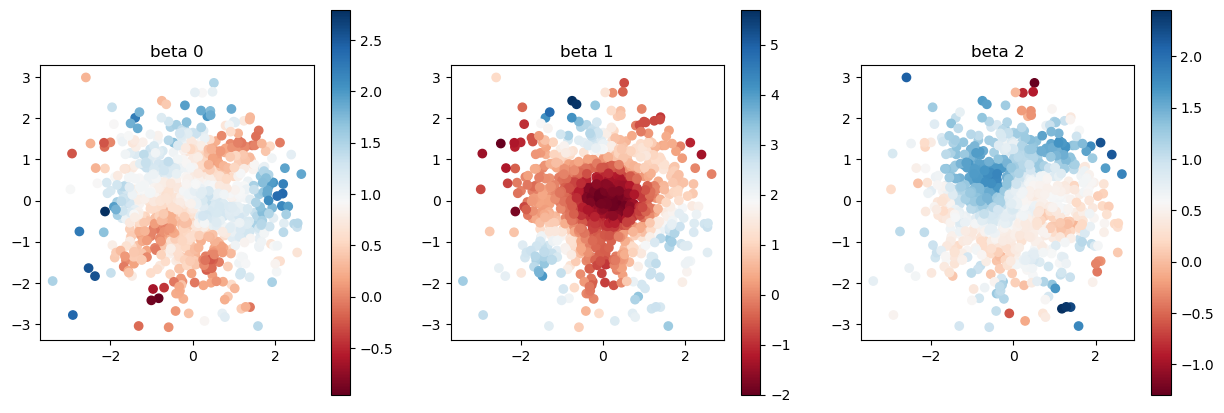

In [14]:
model.set_betas_inner()

print("estimated coefficient after accurate calibration")
plot_scatter(model.betas, sites)

true coefficients


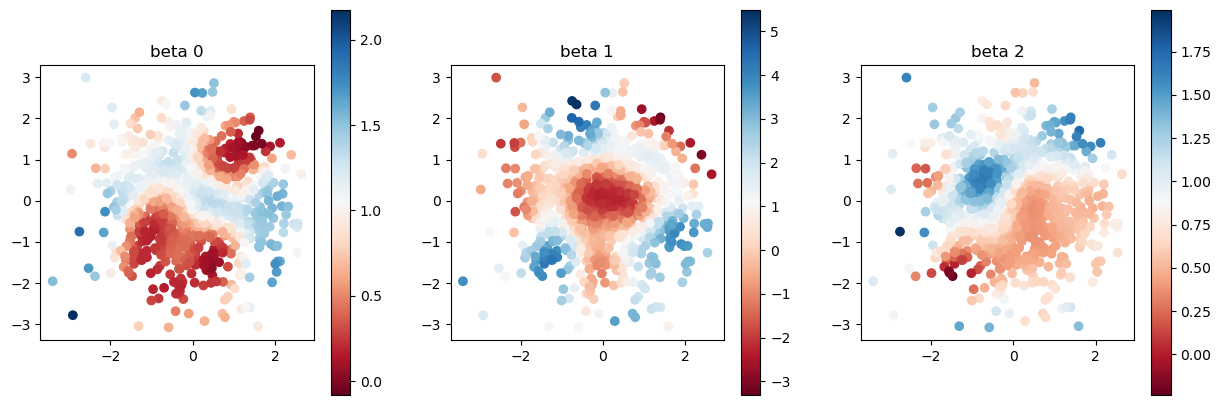

In [15]:
print("true coefficients")
plot_scatter(beta, sites)

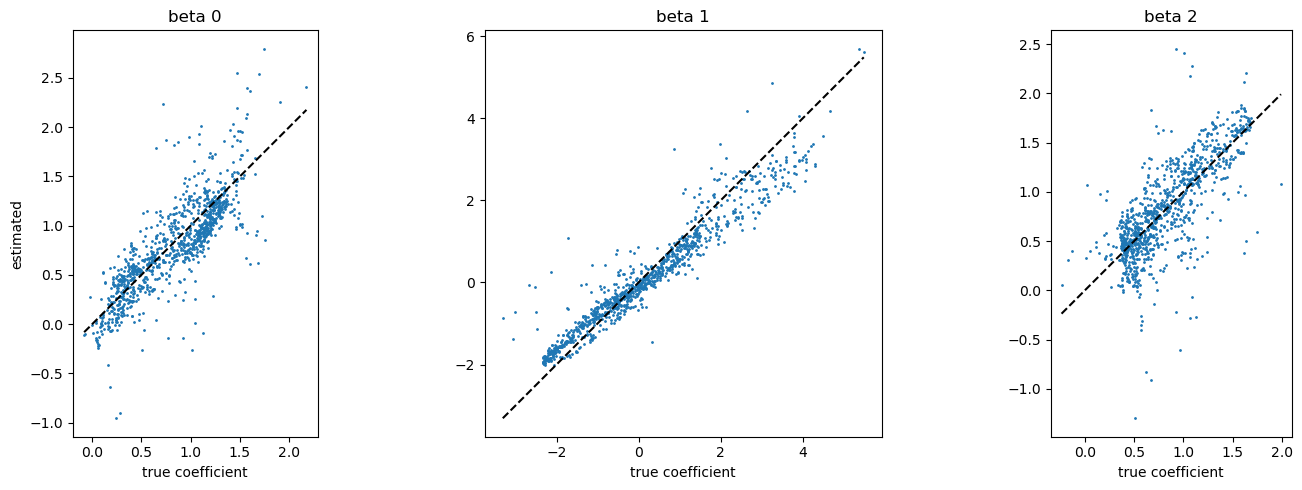

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    axes[i].plot((beta[:,i].min(), beta[:, i].max()), (beta[:,i].min(), beta[:, i].max()), c="k", ls="--")
    axes[i].scatter(beta[:,i], model.betas[:,i], s=1)
    axes[i].set_title(f"beta {i}")
    axes[i].set_aspect("equal")
    axes[i].set_xlabel("true coefficient")
axes[0].set_ylabel("estimated")

plt.tight_layout()
plt.show()


## Reference

- Hayato Nishi, & Yasushi Asami (2024). “Stochastic gradient geographical weighted regression (sgGWR): Scalable bandwidth optimization for geographically weighted regression”. International Journal of Geographical Information Science, Vol. 38, Issue: 2 pp.354-380, https://doi.org/10.1080/13658816.2023.2285471
- Murakami, D., Tsutsumida, N., Yoshida, T., Nakaya, T., & Lu, B. (2021)."Scalable GWR: A Linear-Time Algorithm for Large-Scale Geographically Weighted Regression with Polynomial Kernels". Annals of the American Association of Geographers, 111(2), 459–480. https://doi.org/10.1080/24694452.2020.1774350
